In [3]:
import os
import json
import uuid
import shutil
import time
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import random
from datetime import datetime, timedelta

project_root = os.path.abspath(os.path.join(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Student import Student
from UniversitySalerno import UniversitySalerno
from UniversityRennes import UniversityRennes

# --- Funzioni di utilità per il setup e il cleanup ---

BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
REGISTERED_STUDENTS_FOR_CLEANUP = []


def _delete_dir_if_exists(dir_path):
    if os.path.exists(dir_path) and os.path.isdir(dir_path):
        shutil.rmtree(dir_path)

def _delete_file_if_exists(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)

def cleanup_all_data():
    """Cancella tutti i file creati dal programma."""
    DB_DIR = os.path.join(BASE_DIR, "database")
    _delete_dir_if_exists(DB_DIR)

    KEY_DIR = os.path.join(BASE_DIR, "keys")
    _delete_dir_if_exists(KEY_DIR)

    UNISA_DIR = os.path.join(BASE_DIR, "unisa")
    _delete_dir_if_exists(UNISA_DIR)

    RENNES_DIR = os.path.join(BASE_DIR, "rennes")
    _delete_dir_if_exists(RENNES_DIR)

    for student_data in REGISTERED_STUDENTS_FOR_CLEANUP:
        username = student_data["username"]
        wallet_folder = os.path.join(BASE_DIR, f"wallet-{username}")
        _delete_dir_if_exists(wallet_folder)

    _delete_file_if_exists(os.path.join(BASE_DIR, "shared_blockchain.json"))
    _delete_file_if_exists(os.path.join(BASE_DIR, "revocation_registry.json"))


def generate_fictitious_exams(num_exams: int):
    """
    Genera una lista di esami fittizi.
    Ogni esame avrà un examId, nome, voto, crediti e data.
    """
    exams = []
    exam_names = ["Matematica", "Fisica", "Informatica", "Chimica", "Biologia",
                  "Storia", "Letteratura", "Economia", "Diritto", "Statistica",
                  "Geometria", "Algoritmi", "Reti", "Database", "Sistemi Operativi",
                  "Intelligenza Artificiale", "Sicurezza Informatica", "Programmazione Web"]
    for i in range(num_exams):
        exam_id = str(uuid.uuid4())
        name = random.choice(exam_names) + f" {random.randint(100, 999)}"
        grade = random.randint(18, 30)
        credits = random.choice([3, 6, 9, 12])
        date = (datetime.now() - timedelta(days=random.randint(0, 4*365))).strftime("%Y-%m-%d")

        exams.append({
            "examId": exam_id,
            "name": name,
            "grade": grade,
            "credits": credits,
            "date": date
        })
    return exams


def initialize_system_for_tests(num_fictitious_exams: int = 20):
    """
    Inizializza il sistema per i test, simile al main, ma con output ridotto.
    Genera un numero specificato di esami fittizi.
    Ritorna gli oggetti delle università e degli studenti autenticati.
    """
    cleanup_all_data()
    print("\nConfigurazione del sistema per i test...")
    salerno_university = UniversitySalerno()
    rennes_university = UniversityRennes()
    universities = [salerno_university, rennes_university]
    distribute_dids_among_trusted_folders(universities)

    students_data = [
        {"username": "mario.rossi", "password": "Password1!", "first_name": "Mario", "last_name": "Rossi"}
    ]
    registered_student_objects = []

    for data in students_data:
        username = data["username"]
        password = data["password"]
        first_name = data["first_name"]
        last_name = data["last_name"]
        user_id = str(uuid.uuid4())

        student_obj = Student(username, password, user_id, first_name, last_name)

        if salerno_university.register_student(user_id, username, password, first_name, last_name):
            salerno_university.assign_did_to_student(user_id, student_obj.did, student_obj.get_public_key())

        if rennes_university.register_student(user_id, username, password, first_name, last_name):
            rennes_university.assign_did_to_student(user_id, student_obj.did, student_obj.get_public_key())

        registered_student_objects.append(student_obj)
        REGISTERED_STUDENTS_FOR_CLEANUP.append({"username": username, "user_id": user_id, "first_name": first_name, "last_name": last_name})

    authenticated_students = []
    for student in registered_student_objects:
        user_data = salerno_university.authenticate_student(student.username, student.password)
        if user_data:
            challenge = salerno_university.generate_challenge(student.user_id)
            signature = student.sign(challenge)
            result = salerno_university.verify_challenge_response(student.user_id, signature)
            if result["status"] == "ok":
                authenticated_students.append(student)

    if authenticated_students:
        salerno_university.generate_erasmus_credential(authenticated_students[0])

    fictitious_exams = generate_fictitious_exams(num_fictitious_exams)
    print("Configurazione completata.")
    return salerno_university, rennes_university, authenticated_students, fictitious_exams


def distribute_dids_among_trusted_folders(universities):
    for uni_target in universities:
        os.makedirs(uni_target.trusted_did_folder, exist_ok=True)
        for uni_source in universities:
            if uni_source == uni_target:
                continue
            did_files = [f for f in os.listdir(uni_source.did_folder) if f.endswith("_did.json")]
            for did_file in did_files:
                src = os.path.join(uni_source.did_folder, did_file)
                dst = os.path.join(uni_target.trusted_did_folder, did_file)
                shutil.copy2(src, dst)

--- Analisi 1: Privacy Gain vs Full Disclosure ---

Configurazione del sistema per i test...
🔑 Nuova chiave di crittografia generata e salvata in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/keys/unisa_users_encryption.key
💾 DB salvato correttamente in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/database/unisa_users.json
✅ La blockchain è valida.
Chiavi per did:web:unisa.it generate e salvate.
🔑 Nuova chiave di crittografia generata e salvata in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/keys/rennes_users_encryption.key
💾 DB salvato correttamente in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/database/rennes_users.json
✅ La blockchain è valida.
Chiavi per did:web:rennes.it generate e salvate.
Nuove chiavi generate per lo studente mario.rossi.
Documento DID per mario.rossi salvato in /Users/francesco-daniele/Documents/GitHub/ProjectWorkA

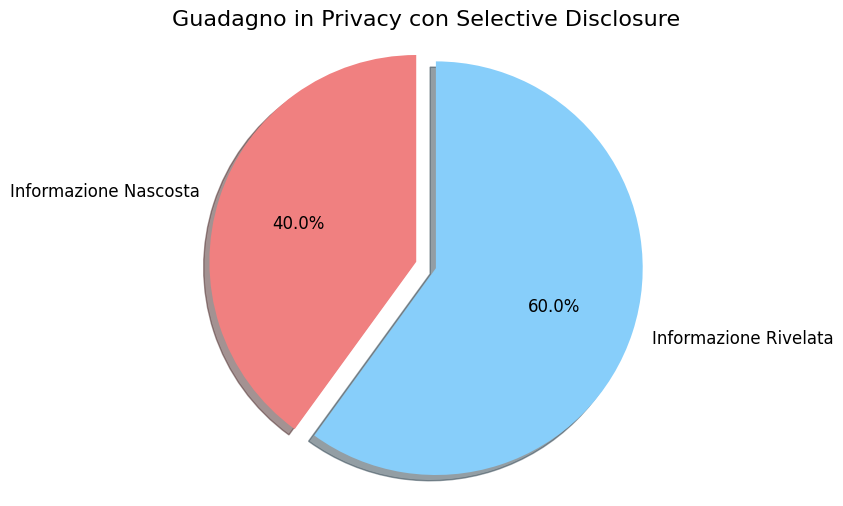

In [4]:
#### Analisi 1: Privacy Gain vs Full Disclosure ####
print("--- Analisi 1: Privacy Gain vs Full Disclosure ---")

salerno_uni, rennes_uni, students, fictitious_exams = initialize_system_for_tests(num_fictitious_exams=10)

if not students:
    print("Nessuno studente autenticato per generare credenziali. Skippo l'analisi.")
else:
    student = students[0]

    rennes_uni.generate_academic_credential(student, fictitious_exams)
    academic_cred = student.load_academic_credential()

    if academic_cred:
        original_claims = []
        # Estrai tutti i campi da tutti gli esami nella credenziale completa
        for exam in academic_cred["credentialSubject"]["exams"]:
            exam_id = exam.get("examId", "")
            for field, value in exam.items():
                original_claims.append(f"{exam_id}_{field}")
        total_attributes_vc = len(original_claims)

        if total_attributes_vc > 0:
            reveal_config = {}
            for exam in academic_cred["credentialSubject"]["exams"]:
                exam_id = exam.get("examId", str(uuid.uuid4()))
                reveal_config[exam_id] = {"name": True, "grade": True, "credits": True} # Riveliamo nome, voto e crediti

            selective_presentation = student.generate_selective_presentation_automated(
                reveal_fields=reveal_config
            )

            if selective_presentation:
                revealed_attributes_count = 0
                disclosed_claims = selective_presentation["verifiableCredential"]["credentialSubject"]["disclosedClaims"]
                for exam_id, fields in disclosed_claims.items():
                    revealed_attributes_count += len(fields)

                # Calcola il privacy gain
                privacy_ratio = (total_attributes_vc - revealed_attributes_count) / total_attributes_vc
                revealed_ratio = revealed_attributes_count / total_attributes_vc

                print(f"\n--- Riepilogo Privacy Gain ---")
                print(f"Attributi totali nella VC: {total_attributes_vc}")
                print(f"Attributi rivelati nella VP: {revealed_attributes_count}")
                print(f"Percentuale di informazione nascosta: {privacy_ratio:.2%} (Privacy Gain)")
                print(f"Percentuale di informazione rivelata: {revealed_ratio:.2%}")

                # Grafico
                labels = ['Informazione Nascosta', 'Informazione Rivelata']
                sizes = [privacy_ratio, revealed_ratio]
                colors = ['lightcoral', 'lightskyblue']
                explode = (0.1, 0)

                fig1, ax1 = plt.subplots(figsize=(8, 6))
                ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                        shadow=True, startangle=90, textprops={'fontsize': 12})
                ax1.axis('equal')
                plt.title('Guadagno in Privacy con Selective Disclosure', fontsize=16)
                plt.show()
            else:
                print("Impossibile generare la presentazione selettiva per l'analisi del privacy gain.")
        else:
            print("Nessun attributo trovato nella credenziale accademica per l'analisi.")
    else:
        print("Credenziale accademica non trovata per l'analisi del privacy gain.")


--- Analisi 2: Efficienza Dimensionale ---

Configurazione del sistema per i test...
🔑 Nuova chiave di crittografia generata e salvata in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/keys/unisa_users_encryption.key
💾 DB salvato correttamente in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/database/unisa_users.json
✅ La blockchain è valida.
Chiavi per did:web:unisa.it generate e salvate.
🔑 Nuova chiave di crittografia generata e salvata in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/keys/rennes_users_encryption.key
💾 DB salvato correttamente in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/database/rennes_users.json
✅ La blockchain è valida.
Chiavi per did:web:rennes.it generate e salvate.
Nuove chiavi generate per lo studente mario.rossi.
Documento DID per mario.rossi salvato in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Proj

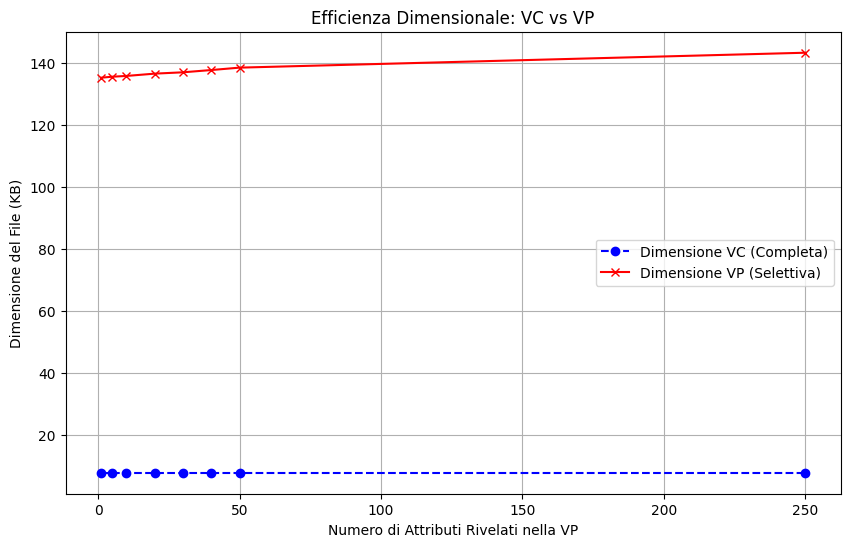

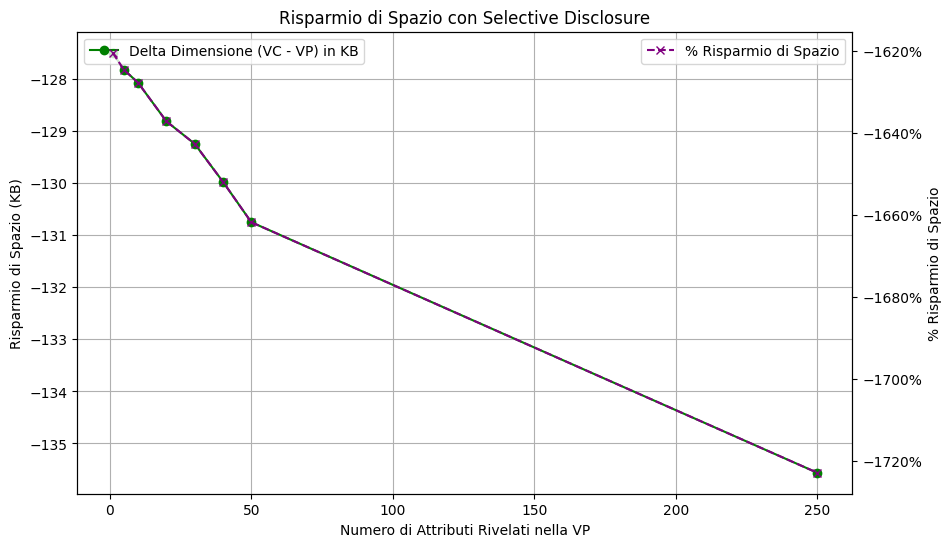

In [5]:
#### Analisi 2: Efficienza Dimensionale ####
print("\n--- Analisi 2: Efficienza Dimensionale ---")


salerno_uni, rennes_uni, students, fictitious_exams_for_size = initialize_system_for_tests(num_fictitious_exams=50)

if not students:
    print("Nessuno studente autenticato per generare credenziali. Skippo l'analisi.")
else:
    student_to_test = students[0]

    # Genera la credenziale accademica iniziale con tutti gli esami fittizi
    rennes_uni.generate_academic_credential(student_to_test, fictitious_exams_for_size)
    academic_cred_full = student_to_test.load_academic_credential()

    if academic_cred_full:
        def get_json_size_kb(data):
            return sys.getsizeof(json.dumps(data, sort_keys=True).encode('utf-8')) / 1024

        original_exams_data = academic_cred_full["credentialSubject"]["exams"]
        all_possible_claims = []
        for exam in original_exams_data:
            exam_id = exam.get("examId", str(uuid.uuid4()))
            for field, value in exam.items():
                all_possible_claims.append({"examId": exam_id, "field": field, "value": value})

        num_claims_to_test = [1, 5, 10, 20, 30, 40, 50, len(all_possible_claims)]
        num_claims_to_test = sorted(list(set(num_claims_to_test)))

        vc_sizes = []
        vp_sizes = []
        delta_sizes = []
        percentage_savings = []

        print(f"Totale claims disponibili nella VC: {len(all_possible_claims)}")

        # La dimensione della VC è costante
        size_vc_full = get_json_size_kb(academic_cred_full)
        print(f"Dimensione VC completa: {size_vc_full:.2f} KB")

        for num_claims in num_claims_to_test:
            current_reveal_fields = {}
            claims_to_reveal_subset = random.sample(all_possible_claims, min(num_claims, len(all_possible_claims)))

            for claim in claims_to_reveal_subset:
                exam_id = claim["examId"]
                field = claim["field"]
                if exam_id not in current_reveal_fields:
                    current_reveal_fields[exam_id] = {}
                current_reveal_fields[exam_id][field] = True

            selective_presentation = student_to_test.generate_selective_presentation_automated(
                reveal_fields=current_reveal_fields
            )

            if selective_presentation:
                size_vp = get_json_size_kb(selective_presentation)
                vc_sizes.append(size_vc_full)
                vp_sizes.append(size_vp)
                delta = size_vc_full - size_vp
                delta_sizes.append(delta)
                percentage_savings.append((delta / size_vc_full) * 100 if size_vc_full > 0 else 0)
                print(f"Claims rivelati: {num_claims}, Dimensione VP: {size_vp:.2f} KB, Risparmio: {percentage_savings[-1]:.2f}%")
            else:
                print(f"Skipping {num_claims} claims: failed to generate VP.")
                vc_sizes.append(size_vc_full)
                vp_sizes.append(np.nan)
                delta_sizes.append(np.nan)
                percentage_savings.append(np.nan)


        # Grafico 1: Dimensione file vs Numero attributi
        fig, ax1 = plt.subplots(figsize=(10, 6))

        ax1.plot(num_claims_to_test, vc_sizes, marker='o', linestyle='--', color='blue', label='Dimensione VC (Completa)')
        ax1.plot(num_claims_to_test, vp_sizes, marker='x', linestyle='-', color='red', label='Dimensione VP (Selettiva)')
        ax1.set_xlabel('Numero di Attributi Rivelati nella VP')
        ax1.set_ylabel('Dimensione del File (KB)')
        ax1.set_title('Efficienza Dimensionale: VC vs VP')
        ax1.legend()
        ax1.grid(True)

        # Grafico 2: Delta dimensione e percentuale di risparmio
        fig, ax2 = plt.subplots(figsize=(10, 6))

        ax2.plot(num_claims_to_test, delta_sizes, marker='o', linestyle='-', color='green', label='Delta Dimensione (VC - VP) in KB')
        ax2.set_xlabel('Numero di Attributi Rivelati nella VP')
        ax2.set_ylabel('Risparmio di Spazio (KB)')
        ax2.set_title('Risparmio di Spazio con Selective Disclosure')
        ax2.legend(loc='upper left')
        ax2.grid(True)

        ax3 = ax2.twinx() # Secondo asse y
        ax3.plot(num_claims_to_test, percentage_savings, marker='x', linestyle='--', color='purple', label='% Risparmio di Spazio')
        ax3.set_ylabel('% Risparmio di Spazio')
        ax3.legend(loc='upper right')
        ax3.yaxis.set_major_formatter(mtick.PercentFormatter())

        plt.show()

    else:
        print("Credenziale accademica non trovata per l'analisi dimensionale.")


--- Analisi 3: Tempi di Generazione e Verifica ---

Configurazione del sistema per i test...
🔑 Nuova chiave di crittografia generata e salvata in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/keys/unisa_users_encryption.key
💾 DB salvato correttamente in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/database/unisa_users.json
✅ La blockchain è valida.
Chiavi per did:web:unisa.it generate e salvate.
🔑 Nuova chiave di crittografia generata e salvata in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/keys/rennes_users_encryption.key
💾 DB salvato correttamente in /Users/francesco-daniele/Documents/GitHub/ProjectWorkAPS/Project Work APS/Project/database/rennes_users.json
✅ La blockchain è valida.
Chiavi per did:web:rennes.it generate e salvate.
Nuove chiavi generate per lo studente mario.rossi.
Documento DID per mario.rossi salvato in /Users/francesco-daniele/Documents/GitHub/ProjectWork

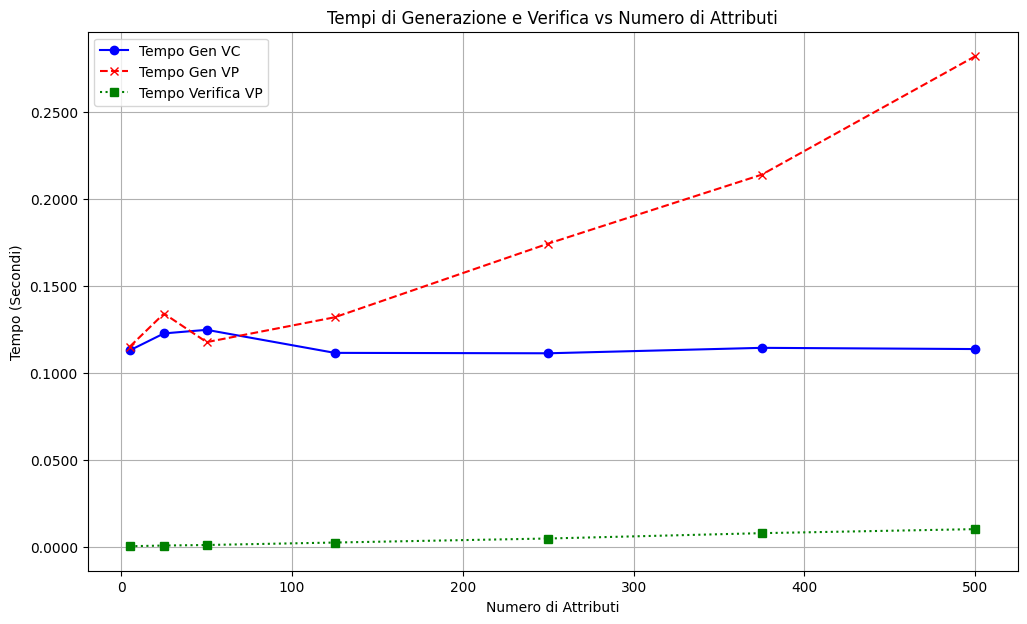

In [7]:
print("\n--- Analisi 3: Tempi di Generazione e Verifica ---")

salerno_uni, rennes_uni, students, fictitious_exams_for_perf = initialize_system_for_tests(num_fictitious_exams=100)

if not students:
    print("Nessuno studente autenticato per generare credenziali. Skippo l'analisi.")
else:
    student_for_perf = students[0]
    student_credentials_path = os.path.join(student_for_perf.get_wallet_path(), "credentials")
    os.makedirs(student_credentials_path, exist_ok=True)

    if not fictitious_exams_for_perf:
        print("Nessun dato esame disponibile per la generazione di credenziali. Skippo l'analisi.")
    else:
        num_exams_to_test = [1, 5, 10, 25, 50, 75, 100]
        num_exams_to_test = [n for n in num_exams_to_test if n <= len(fictitious_exams_for_perf)]
        num_exams_to_test = sorted(list(set(num_exams_to_test)))

        gen_vc_times = []
        gen_vp_times = []
        verify_vp_times = []
        effective_num_attributes = []

        num_iterations = 1
        print(f"Simulando con {num_iterations} iterazioni per punto dati.")

        for num_exams in num_exams_to_test:
            exams_subset = fictitious_exams_for_perf[:num_exams]
            current_total_attributes = num_exams * 5
            effective_num_attributes.append(current_total_attributes)

            academic_cred_filepath = os.path.join(student_credentials_path, f"{student_for_perf.username}_academic_credential.json")
            erasmus_cred_filepath = os.path.join(student_credentials_path, f"{student_for_perf.username}_erasmus_credential.json")
            vp_filepath = os.path.join(student_credentials_path, f"{student_for_perf.username}_vp.json")

            if os.path.exists(academic_cred_filepath):
                os.remove(academic_cred_filepath)
            if os.path.exists(erasmus_cred_filepath):
                os.remove(erasmus_cred_filepath)
            if os.path.exists(vp_filepath):
                os.remove(vp_filepath)

            start_time = time.time()
            rennes_uni.generate_academic_credential(student_for_perf, exams_subset)
            end_time = time.time()
            avg_gen_vc_time = (end_time - start_time)
            gen_vc_times.append(avg_gen_vc_time)
            print(f"Gen VC ({num_exams} esami, {current_total_attributes} attr): {avg_gen_vc_time:.4f} s")

            academic_cred_for_vp = student_for_perf.load_academic_credential()
            if academic_cred_for_vp:
                reveal_all_config = {}
                for exam in academic_cred_for_vp["credentialSubject"]["exams"]:
                    exam_id = exam.get("examId", str(uuid.uuid4()))
                    reveal_all_config[exam_id] = {field: True for field in exam if field != "examId"}

                start_time = time.time()
                student_for_perf.generate_selective_presentation_automated(reveal_fields=reveal_all_config)
                end_time = time.time()
                avg_gen_vp_time = (end_time - start_time)
                gen_vp_times.append(avg_gen_vp_time)
                print(f"Gen VP ({num_exams} esami, {current_total_attributes} attr): {avg_gen_vp_time:.4f} s")

                if os.path.exists(vp_filepath):
                    with open(vp_filepath, 'r') as f:
                        vp_to_verify = json.load(f)
                    start_time = time.time()
                    salerno_uni.verify_selective_presentation(vp_to_verify)
                    end_time = time.time()
                    avg_verify_vp_time = (end_time - start_time)
                    verify_vp_times.append(avg_verify_vp_time)
                    print(f"Verifica VP ({num_exams} esami, {current_total_attributes} attr): {avg_verify_vp_time:.4f} s")
                else:
                    print(f"VP non trovata per la verifica per {num_exams} esami. Skippo la misurazione.")
                    verify_vp_times.append(np.nan)
            else:
                print(f"Credenziale accademica non generata per {num_exams} esami. Skippo VP generation/verification.")
                gen_vp_times.append(np.nan)
                verify_vp_times.append(np.nan)

        plt.figure(figsize=(12, 7))
        plt.plot(effective_num_attributes, gen_vc_times, marker='o', linestyle='-', color='blue', label='Tempo Gen VC')
        plt.plot(effective_num_attributes, gen_vp_times, marker='x', linestyle='--', color='red', label='Tempo Gen VP')
        plt.plot(effective_num_attributes, verify_vp_times, marker='s', linestyle=':', color='green', label='Tempo Verifica VP')
        plt.xlabel('Numero di Attributi')
        plt.ylabel('Tempo (Secondi)')
        plt.title('Tempi di Generazione e Verifica vs Numero di Attributi')
        plt.legend()
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))
        plt.show()


In [28]:
cleanup_all_data()